In [1]:
import torch
import numpy as np

# Singular Value Decomposition

In [2]:
d, k = 10, 10

# This way we can generate a rank-deficient matrix
W_rank = 2
W = torch.randn(d,W_rank) @ torch.randn(W_rank,k)
print(W)

tensor([[-1.2662e+00, -7.9020e-01, -8.6349e-01, -1.2097e+00,  2.6849e+00,
          1.8157e+00, -2.2918e+00, -4.1155e-01,  9.8558e-01, -1.4959e+00],
        [ 2.3244e-01,  1.2181e-01,  1.6690e-01,  2.3408e-01, -4.5089e-01,
         -2.8171e-01,  3.8632e-01,  7.7935e-02, -1.8476e-01,  2.8698e-01],
        [ 3.5136e-01, -5.4567e-01,  5.1562e-01,  7.3121e-01,  6.3635e-01,
          1.1939e+00, -4.9542e-01,  1.9275e-01, -3.9965e-01,  8.2235e-01],
        [-3.2196e-01, -8.6035e-02, -2.6101e-01, -3.6699e-01,  4.7522e-01,
          2.0668e-01, -4.1280e-01, -1.1644e-01,  2.6955e-01, -4.4152e-01],
        [-1.8177e+00,  5.8720e-01, -1.8608e+00, -2.6268e+00,  7.4545e-01,
         -1.2144e+00, -7.4373e-01, -7.6757e-01,  1.6988e+00, -3.0640e+00],
        [-1.0091e-02, -6.3435e-02,  1.3736e-02,  1.9905e-02,  1.2458e-01,
          1.4128e-01, -1.0277e-01,  2.5875e-03, -1.5702e-03,  1.8499e-02],
        [-1.2281e+00,  5.2907e-01, -1.3050e+00, -1.8432e+00,  2.6468e-01,
         -1.1142e+00, -3.0677e-0

In [3]:
W_rank = np.linalg.matrix_rank(W)
print(f'Rank of W: {W_rank}')

Rank of W: 2


In [4]:
# Calulate SVD

# Perform SVD on W (W = UxSxV^T)
U, S, V = torch.svd(W)

print(f"Shape of U {U.shape}")
print(f"Shape of S {S.shape}")
print(f"Shape of V {V.shape}")

# For rank-r factorization, keep only the first r singular values (and corresponding columns of U and V)
U_r = U[:, :W_rank]
S_r = torch.diag(S[:W_rank])
V_r = V[:, :W_rank].t()  # Transpose V_r to get the right dimensions

# Compute B = U_r * S_r and A = V_r
B = U_r @ S_r
A = V_r
print(f'Shape of B: {B.shape}')
print(f'Shape of A: {A.shape}')

Shape of U torch.Size([10, 10])
Shape of S torch.Size([10])
Shape of V torch.Size([10, 10])
Shape of B: torch.Size([10, 2])
Shape of A: torch.Size([2, 10])


In [6]:
U[:, :W_rank].shape

torch.Size([10, 2])

In [7]:
S[:W_rank].shape

torch.Size([2])

In [8]:
# Generate random bias and input
bias = torch.randn(d)
x = torch.randn(d)

# Compute y = Wx + bias
y = W @ x + bias
# Compute y' = (B*A)x + bias
y_prime = (B @ A) @ x + bias

print("Original y using W:\n", y)
print("")
print("y' computed using BA:\n", y_prime)

Original y using W:
 tensor([ 5.0409, -0.5285, -2.6110,  2.8462,  7.4054, -0.3896,  6.0332,  3.3849,
         6.6832,  3.1293])

y' computed using BA:
 tensor([ 5.0409, -0.5285, -2.6110,  2.8462,  7.4054, -0.3896,  6.0332,  3.3849,
         6.6832,  3.1293])


In [9]:
print("Total parameters of W: ", W.nelement())
print("Total parameters of B and A: ", B.nelement() + A.nelement())

Total parameters of W:  100
Total parameters of B and A:  40


# Train Image Classifier with LORA

In [10]:
import torch
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/talal/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
_ = torch.manual_seed(42)

In [13]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, transform=transform)
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Load the MNIST test set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:


class Net(nn.Module):
    def __init__(self, hidden_size=[1000,2000]):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(28*28, hidden_size[0]) 
        self.linear2 = nn.Linear(hidden_size[0], hidden_size[1]) 
        self.linear3 = nn.Linear(hidden_size[1], 10)
        self.relu = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

model = Net()

In [16]:


cross_el = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

total_iterations = 0
epochs = 2
model.to(device)
for epoch in range(epochs):
    model.train()

    loss_sum = 0
    num_iterations = 0

    data_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}')
    for data in data_iterator:
        x, y = data
        x = x.to(device)
        y = y.to(device)
       
        optimizer.zero_grad()
        output = model(x.view(-1, 28*28))
        loss = cross_el(output, y)
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()

print(f"Avg loss: {loss_sum/len(data_iterator)}")
        

Epoch 2: 100%|██████████| 6000/6000 [06:04<00:00, 16.44it/s]

Avg loss: 0.13057755585653516


In [17]:
original_weights = {}
for name, param in model.named_parameters():
    original_weights[name] = param.clone().detach()

In [18]:
total_parameters_original = 0
for index, layer in enumerate([model.linear1, model.linear2, model.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10])
Total number of parameters: 2,807,010


# Lets Implement LoRA Adaptation mention in paper

![Screenshot from 2024-05-27 18-44-20.png](<attachment:Screenshot from 2024-05-27 18-44-20.png>)
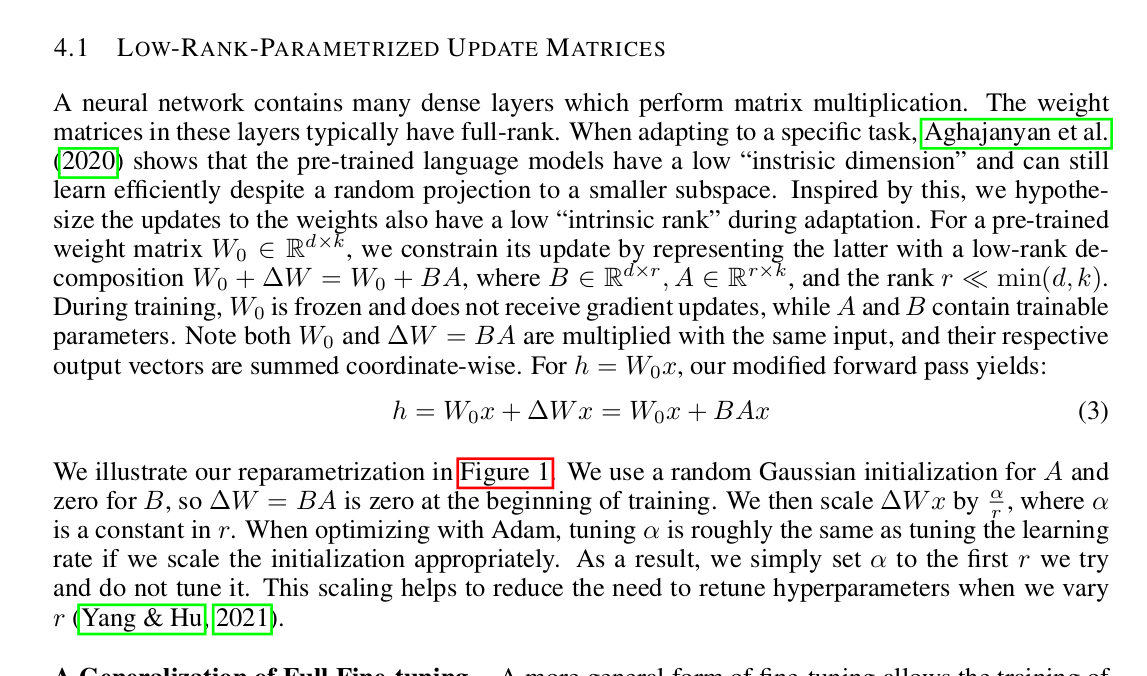

So here we need to create 2 low rank matrices and when we start training we basically add those matrices to original weight matrix.

Only LoRA have enable gradient during finetuning

In [19]:
class LoRAParametrization(nn.Module):
    def __init__(self, features_in, features_out, rank=1, alpha=1, device='cpu'):
        super().__init__()
        self.lora_A = nn.Parameter(torch.zeros((rank,features_out)).to(device))
        self.lora_B = nn.Parameter(torch.zeros((features_in, rank)).to(device))
        nn.init.normal_(self.lora_A, mean=0, std=1)
        
        self.scale = alpha / rank
        self.enabled = True

    def forward(self, original_weights):
        if self.enabled:
            # Return W + (B*A)*scale
            return original_weights + torch.matmul(self.lora_B, self.lora_A).view(original_weights.shape) * self.scale
        else:
            return original_weights

In [20]:
import torch.nn.utils.parametrize as parametrize

def linear_layer_parameterization(layer, device, rank=1, lora_alpha=1):
    features_in, features_out = layer.weight.shape
    return LoRAParametrization(
        features_in, features_out, rank=rank, alpha=lora_alpha, device=device
    )

parametrize.register_parametrization(
    model.linear1, "weight", linear_layer_parameterization(model.linear1, device)
)
parametrize.register_parametrization(
    model.linear2, "weight", linear_layer_parameterization(model.linear2, device)
)
parametrize.register_parametrization(
    model.linear3, "weight", linear_layer_parameterization(model.linear3, device)
)


def enable_disable_lora(enabled=True):
    for layer in [model.linear1, model.linear2, model.linear3]:
        layer.parametrizations["weight"][0].enabled = enabled

In [21]:
# Freeze the non-Lora parameters
for name, param in model.named_parameters():
    if 'lora' not in name:
        print(f'Freezing non-LoRA parameter {name}')
        param.requires_grad = False

Freezing non-LoRA parameter linear1.bias
Freezing non-LoRA parameter linear1.parametrizations.weight.original
Freezing non-LoRA parameter linear2.bias
Freezing non-LoRA parameter linear2.parametrizations.weight.original
Freezing non-LoRA parameter linear3.bias
Freezing non-LoRA parameter linear3.parametrizations.weight.original


In [22]:
cross_el = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

total_iterations = 0
epochs = 2
model.to(device)
for epoch in range(epochs):
    model.train()

    loss_sum = 0
    num_iterations = 0

    data_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}')
    for data in data_iterator:
        x, y = data
        x = x.to(device)
        y = y.to(device)
       
        optimizer.zero_grad()
        output = model(x.view(-1, 28*28))
        loss = cross_el(output, y)
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()

print(f"Avg loss: {loss_sum/len(data_iterator)}")

Epoch 2: 100%|██████████| 6000/6000 [03:57<00:00, 25.23it/s]

Avg loss: 0.04798788963797184
